### Stochastic model of wealth distribution
We use the model $\frac{dw}{dt} = J(1-w) + \sigma w \xi(t)$ to describe how the wealth $w(t)$ owned by an agent changes over time, where $w$ is normalized to that $w=1$ corresponds to the mean of wealth across the population. The term $J(1-w)$ reflects exchange of monies amongs members of the population. The term $\sigma w \xi(t)$ incorporates stochastic white noise into wealth generation and loss.

In [1]:
# Load modules
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Apply Euler-Maruyama method to solve SDE
def solveSDE(J, sigma, x0, T, dt):
    N = int(T/dt)
    t = np.linspace(0, T, N)
    x = np.zeros(N)
    x[0] = x0
    
    for n in range(N-1):
        x[n+1] = x[n] + J*(1-x[n])*dt + sigma*x[n]*np.random.randn()*np.sqrt(dt)
    return x, t

We now solve the stochastic differential equation $\frac{dw}{dt}=J(1-w)+\sigma w\xi(t)$ for many different noise realizations and compute the wealth mean of these computation (which should be 1 due to our normalization). The figure can be enlarged by picking the rectangle tool in the menu to the left of the graph and using the mouse to select a rectangle -- the notebook will enlarge the selected region.

<IPython.core.display.Javascript object>


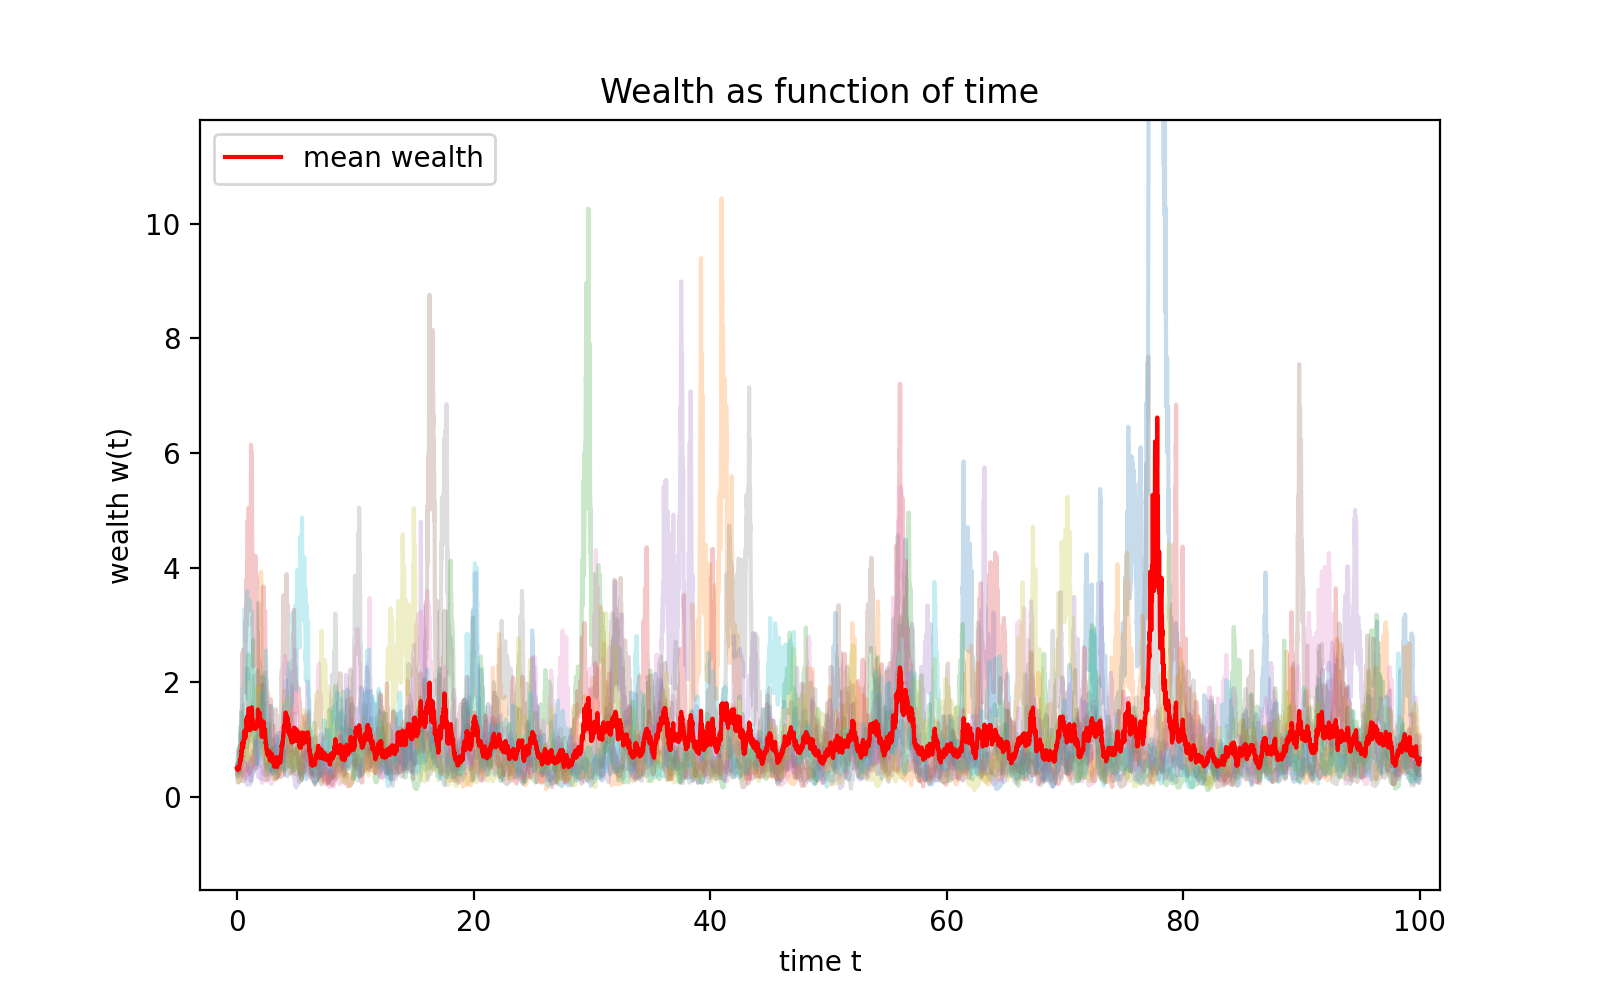

In [3]:
# Set system parameters
J = 1.0
sigma = 1.0
x0 = 0.5

#Set numerical parameters
dt = 0.01  # time step
T = 100    # total time

# Create figure
fig = plt.subplots(1, 1, figsize=(8, 5))

# Compute and plot solutions
mean = np.zeros(int(T/dt))
M = 10
for m in range(M):
    x, t = solveSDE(J, sigma, x0, T, dt)
    mean += x
    plt.plot(t, x, alpha=0.25)
plt.plot(t, mean/M, color='r', label='mean wealth')
plt.title('Wealth as function of time')
plt.xlabel('time t')
plt.ylabel('wealth w(t)')
plt.legend()
plt.show()

Next, we provide functions to calculate probability density functions based on our simulations and the predictions from the stationary solution of the Fokker-Planck equation.

In [4]:
# Create histograms and probability density function
def computePDF(J, sigma, ntrials, T, dt):
    N = int(T/dt)
    X = np.random.randn(ntrials)
    for n in range(N-1):
        X += J*(1-X)*dt + sigma*X*np.random.randn(ntrials)*np.sqrt(dt)
    return X

# Probability distributions from Fokker-Planck equation
def predictedPDF(w, J, sigma):
    mu = 1+2*J/sigma**2
    y = 1/(w**(1+mu)*np.exp((mu-1)/w))
    return y/np.sum(y)

We now compare the wealth distributions of many trials of the stochastic differential equation with the predicted distribution from the Fokker-Planck equation for different values of the parameter J.

<IPython.core.display.Javascript object>


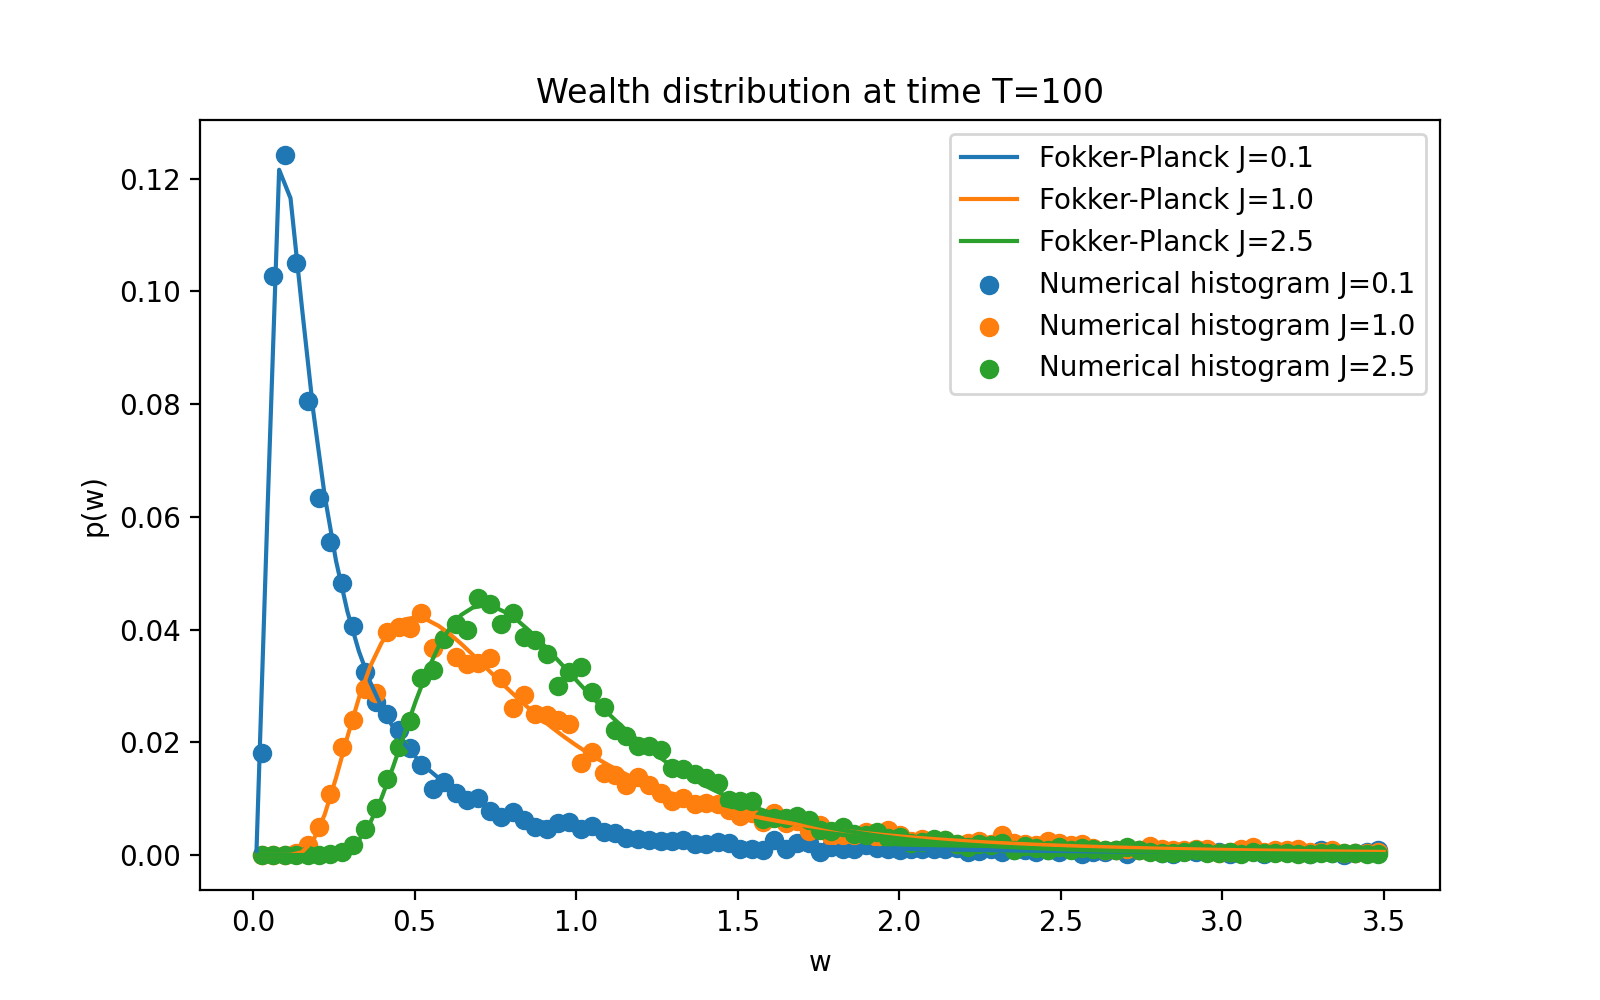

In [5]:
# Define bins for histogram
ntrials = 10000
nbins = 100
bins = np.linspace(0.01, 3.5, nbins)
binCenters = (bins[1:] + bins[:-1])/2

# Define range of J values 
Jvalues = np.array([0.1, 1.0, 2.5])

# Create figure
fig = plt.subplots(1, 1, figsize=(8, 5))
M = Jvalues.size
Y = np.zeros((M, nbins))
Z = np.zeros((M, nbins-1))

# Compute and plot solutions
for m in range(M):
    X = computePDF(Jvalues[m], sigma, ntrials, T, dt)
    Y[m, :] = predictedPDF(bins, Jvalues[m], sigma)
    Z[m, :], _ = np.histogram(X, bins=bins)
    Z[m, :] = Z[m, :]/ntrials
    plt.scatter(binCenters, Z[m, :], label='Numerical histogram J=' + str(Jvalues[m]))
    plt.plot(bins, Y[m, :], label='Fokker-Planck J=' + str(Jvalues[m]))
plt.title('Wealth distribution at time T=' + str(T))
plt.xlabel('w')
plt.ylabel('p(w)')
plt.legend()
plt.show()

Finally, we check whether the tail of the integrals of these distributions exhibit the expected power law behavior $1/w^\mu$ for the Pareto index $\mu=1+2J/\sigma^2$.

<IPython.core.display.Javascript object>


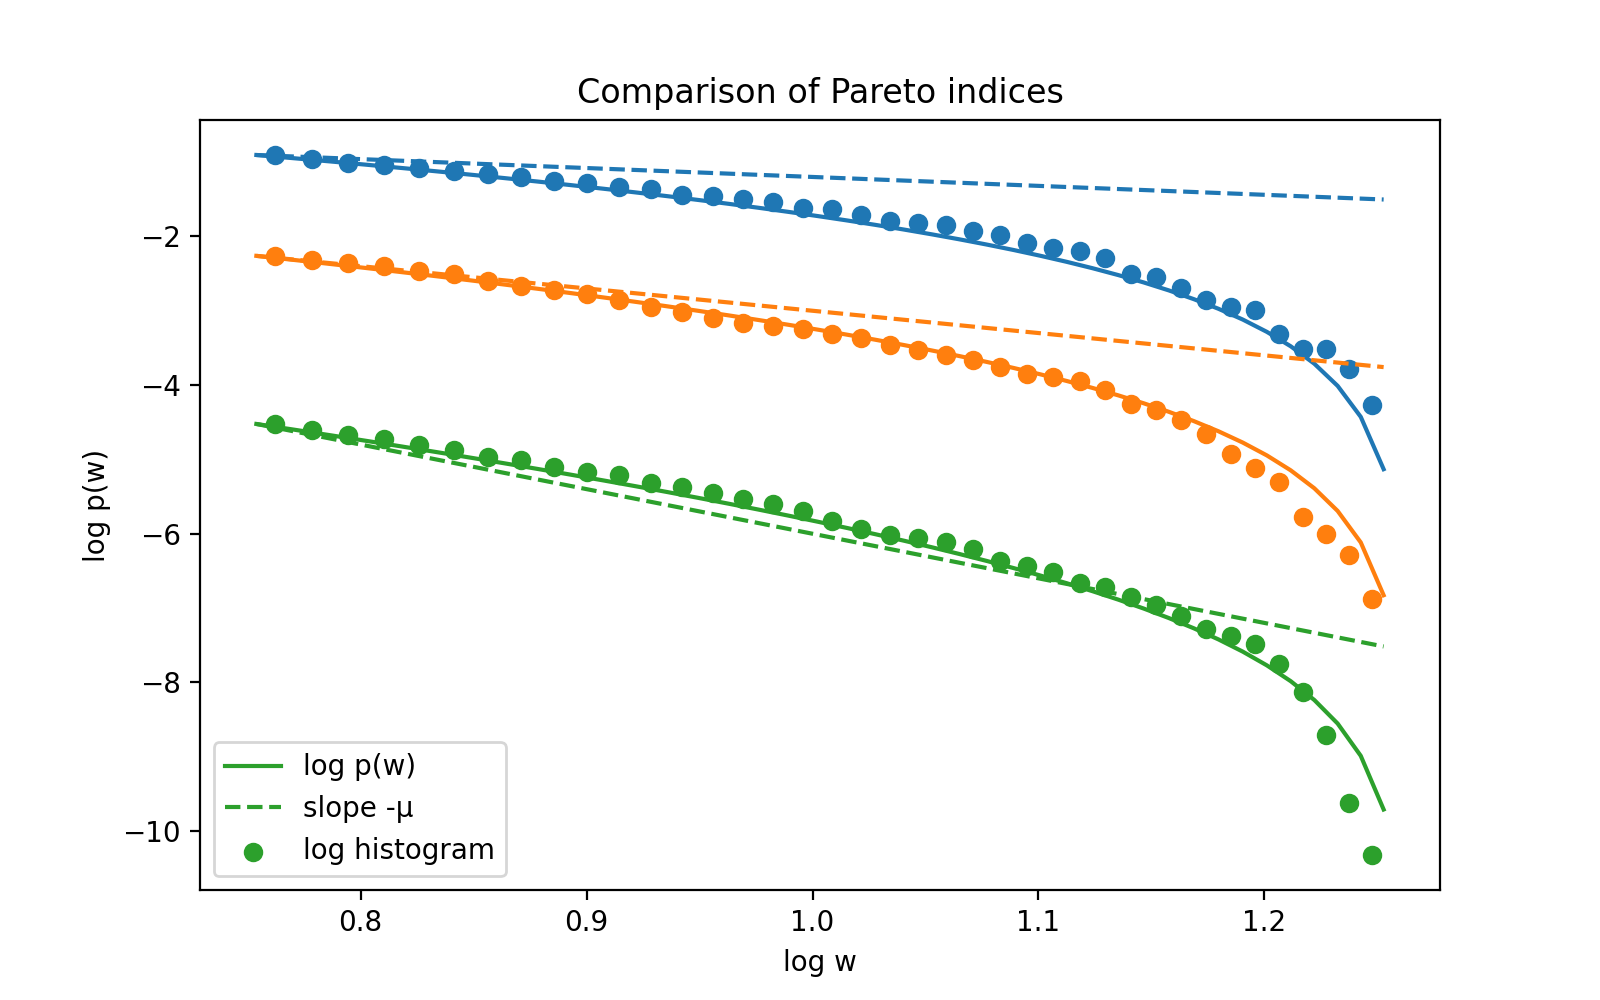

In [6]:
k = int(0.6*nbins)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

np.seterr(divide = 'ignore')
for m in range(M):
    mu = 1+2*Jvalues[m]/sigma**2
    Ydist = Y[m,:]
    Ydist = np.cumsum(Ydist[::-1])[::-1] 
    Zdist = Z[m,:]
    Zdist = np.cumsum(Zdist[::-1])[::-1] 

    slope, _ = np.polyfit(np.log(bins[k:]), np.log(Y[m, k:]), 1)
    c1 = -np.log(Ydist[k]) - mu*np.log(bins[k])
    c2 = -np.log(Zdist[k]) - mu*np.log(bins[k])
    
    color = next(ax._get_lines.prop_cycler)['color']
    line1, = plt.plot(np.log(bins[k:]), c1 + np.log(Ydist[k:]), color=color, linestyle='-', label='log p(w) for J=' + str(Jvalues[m]))
    line2 = plt.scatter(np.log(binCenters[k:]), c2 + np.log(Zdist[k:]), color=color, label='log simulations for J=' + str(Jvalues[m]))
    line3, = plt.plot(np.log(bins[k:]), -mu*np.log(bins[k:]), color=color, linestyle='--', label='predicted slope for J=' + str(Jvalues[m]))
np.seterr(divide = 'warn')

plt.title('Comparison of Pareto indices')
plt.xlabel('log w')
plt.ylabel('log p(w)')
plt.legend((line1, line3, line2), ('log p(w)', 'slope -μ', 'log histogram'))
plt.show()